SimpleNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 100/500 train_loss=0.0098 test_loss=0.0105
Epoch 200/500 train_loss=0.0095 test_loss=0.0109
Epoch 300/500 train_loss=0.0105 test_loss=0.0103
Epoch 400/500 train_loss=0.0098 test_loss=0.0104
Epoch 500/500 train_loss=0.0096 test_loss=0.0103


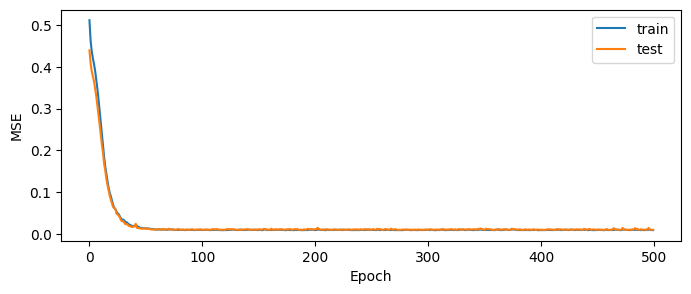

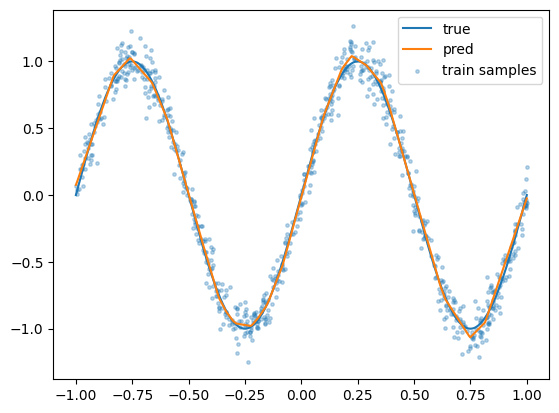

In [1]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Target function
def f1d(x):
    return torch.sin(2 * torch.pi * x)

# Data: sample uniformly on [-1, 1]
n_samples = 1000
X = (2 * torch.rand(n_samples, 1) - 1.0)            # shape (n,1) in [-1,1]
y = f1d(X) + 0.1 * torch.randn(n_samples, 1)        # explicit shape match

# Train/test split
train_n = int(0.8 * n_samples)
perm = torch.randperm(n_samples)
X_train, y_train = X[perm[:train_n]], y[perm[:train_n]]
X_test, y_test   = X[perm[train_n:]], y[perm[train_n:]]

# DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Simple model (register activations so print(model) shows them)
class SimpleNN(nn.Module):
    def __init__(self, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hid),
            nn.ReLU(),
            nn.Linear(hid, hid),
            nn.ReLU(),
            nn.Linear(hid, 1)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleNN(hid=64)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop (mini-batch)
n_epochs = 500
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    train_losses.append(epoch_loss / train_n)

    # eval on test set
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(X_test), y_test).item()
        test_losses.append(test_loss)

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} train_loss={train_losses[-1]:.4f} test_loss={test_losses[-1]:.4f}")

# Plot loss curves
plt.figure(figsize=(8,3))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.show()

# Plot learned function vs true on a dense grid inside [-1,1]
xs = torch.linspace(-1, 1, 400).unsqueeze(1)
model.eval()
with torch.no_grad():
    ys_pred = model(xs)
plt.figure()
plt.plot(xs.numpy(), f1d(xs).numpy(), label='true')
plt.plot(xs.numpy(), ys_pred.numpy(), label='pred')
plt.scatter(X_train.numpy(), y_train.numpy(), s=6, alpha=0.3, label='train samples')
plt.legend(); plt.show()